In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem.porter import PorterStemmer # used for stemming
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # classifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wasan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wasan\AppData\Roaming\nltk_data...


True

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wasan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [5]:
train_data = pd.read_csv(r"C:\Users\wasan\OneDrive\Desktop\Fake News Data\train.csv")
test_data = pd.read_csv(r"C:\Users\wasan\OneDrive\Desktop\Fake News Data\test.csv")

In [6]:
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [7]:
# Checking Shape
train_data.shape

(20800, 5)

In [8]:
test_data.shape

(5200, 4)

In [9]:
# Checking data info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


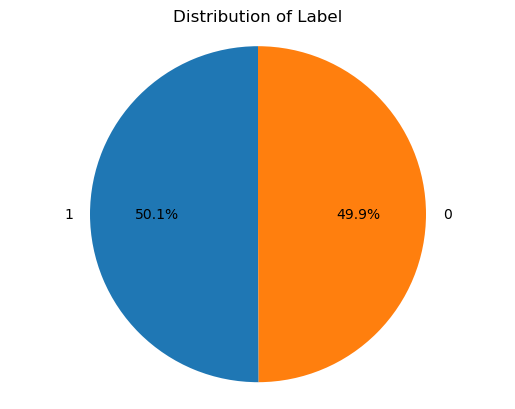

In [10]:
labels = train_data['label'].value_counts().index.to_list()
sizes = train_data['label'].value_counts().to_list()

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures a circular pie chart
plt.title("Distribution of Label")
plt.show()

In [11]:
def create_new_text(row):
    return "Author(s): " + row["author"] + "\n" + "Title: " + row["title"] + "\n\n" + row["text"]

train_data['author'] = train_data['author'].fillna('')
train_data['title'] = train_data['title'].fillna('')
train_data['text'] = train_data['text'].fillna('')
train_data['new_text'] = train_data.apply(create_new_text, axis=1)

test_data['author'] = test_data['author'].fillna('')
test_data['title'] = test_data['title'].fillna('')
test_data['text'] = test_data['text'].fillna('')
test_data['new_text'] = test_data.apply(create_new_text, axis=1)

In [12]:
train_data.head()

,id,title,author,text,label,new_text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Author(s): Darrell Lucus\nTitle: House Dem Aid...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,Author(s): Daniel J. Flynn\nTitle: FLYNN: Hill...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Author(s): Consortiumnews.com\nTitle: Why the ...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Author(s): Jessica Purkiss\nTitle: 15 Civilian...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Author(s): Howard Portnoy\nTitle: Iranian woma...


In [13]:
# Load stopwords
stop_words = set(stopwords.words('english'))
# Define function to remove stopwords from a string
def remove_stopwords(text):
    filtered_words = [word for word in text.split() if word.lower() not in stop_words]
    return ' '.join(filtered_words)
# Apply function to the 'text' column
train_data['new_text'] = train_data['new_text'].apply(remove_stopwords)
test_data['new_text'] = test_data['new_text'].apply(remove_stopwords)

In [14]:
train_data['new_text'].head()

0    Author(s): Darrell Lucus Title: House Dem Aide...
1    Author(s): Daniel J. Flynn Title: FLYNN: Hilla...
2    Author(s): Consortiumnews.com Title: Truth Mig...
3    Author(s): Jessica Purkiss Title: 15 Civilians...
4    Author(s): Howard Portnoy Title: Iranian woman...
Name: new_text, dtype: object

In [15]:
import string
# Define a string of all punctuations
punctuations = string.punctuation

# Define function to clean and remove punctuations from a string
def clean_text(text):
    clean_text = text.translate(str.maketrans('', '', punctuations))
    return clean_text

# Apply function to the 'text' column
train_data['new_text'] = train_data['new_text'].apply(clean_text)
test_data['new_text'] = test_data['new_text'].apply(clean_text)


In [16]:
train_data['new_text'].head()

0    Authors Darrell Lucus Title House Dem Aide Did...
1    Authors Daniel J Flynn Title FLYNN Hillary Cli...
2    Authors Consortiumnewscom Title Truth Might Ge...
3    Authors Jessica Purkiss Title 15 Civilians Kil...
4    Authors Howard Portnoy Title Iranian woman jai...
Name: new_text, dtype: object

In [17]:
# Define function to clean and remove repeating characters from a string
def clean_text(text):
    clean_text = re.sub(r'(\w)\1+', r'\1', text)
    return clean_text

# Apply function to 'text' column
train_data['new_text'] = train_data['new_text'].apply(clean_text)
test_data['new_text'] = test_data['new_text'].apply(clean_text)

In [18]:
train_data['new_text'].head()

0    Authors Darel Lucus Title House Dem Aide Didn’...
1    Authors Daniel J Flyn Title FLYN Hilary Clinto...
2    Authors Consortiumnewscom Title Truth Might Ge...
3    Authors Jesica Purkis Title 15 Civilians Kiled...
4    Authors Howard Portnoy Title Iranian woman jai...
Name: new_text, dtype: object

In [19]:
# Define function to clean and remove URLs from a string
def clean_text(text):
    clean_text = re.sub(r'http\S+', '', text)
    return clean_text

# Apply function to 'text' column
train_data['new_text'] = train_data['new_text'].apply(clean_text)
test_data['new_text'] = test_data['new_text'].apply(clean_text)

In [20]:
train_data['new_text'].head()

0    Authors Darel Lucus Title House Dem Aide Didn’...
1    Authors Daniel J Flyn Title FLYN Hilary Clinto...
2    Authors Consortiumnewscom Title Truth Might Ge...
3    Authors Jesica Purkis Title 15 Civilians Kiled...
4    Authors Howard Portnoy Title Iranian woman jai...
Name: new_text, dtype: object

In [21]:
# Define function to clean and remove numeric numbers from a string
def clean_text(text):
    clean_text = re.sub(r'\d+', '', text)
    return clean_text

# Apply function to 'text' column
train_data['new_text'] = train_data['new_text'].apply(clean_text)
test_data['new_text'] = test_data['new_text'].apply(clean_text)


In [22]:
train_data['new_text'].head()

0    Authors Darel Lucus Title House Dem Aide Didn’...
1    Authors Daniel J Flyn Title FLYN Hilary Clinto...
2    Authors Consortiumnewscom Title Truth Might Ge...
3    Authors Jesica Purkis Title  Civilians Kiled S...
4    Authors Howard Portnoy Title Iranian woman jai...
Name: new_text, dtype: object

In [23]:
# Define function to tokenize the text of a tweet
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Apply function to 'text' column
train_data['new_text'] = train_data['new_text'].apply(tokenize_text)
test_data['new_text'] = test_data['new_text'].apply(tokenize_text)

In [24]:
train_data["new_text"].head()

0    [Authors, Darel, Lucus, Title, House, Dem, Aid...
1    [Authors, Daniel, J, Flyn, Title, FLYN, Hilary...
2    [Authors, Consortiumnewscom, Title, Truth, Mig...
3    [Authors, Jesica, Purkis, Title, Civilians, Ki...
4    [Authors, Howard, Portnoy, Title, Iranian, wom...
Name: new_text, dtype: object

In [25]:
# Create a Porter stemmer object
stemmer = PorterStemmer()

# Define function to apply stemming to the tokens of a tweet
def stem_tokens(tokens):
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

# Apply function to 'text' column
train_data['new_text'] = train_data['new_text'].apply(stem_tokens)
test_data['new_text'] = test_data['new_text'].apply(stem_tokens)

In [26]:
train_data["new_text"].head()

0    [author, darel, lucu, titl, hous, dem, aid, di...
1    [author, daniel, j, flyn, titl, flyn, hilari, ...
2    [author, consortiumnewscom, titl, truth, might...
3    [author, jesica, purki, titl, civilian, kile, ...
4    [author, howard, portnoy, titl, iranian, woman...
Name: new_text, dtype: object

In [27]:
# Create a WordNet lemmatizer object
lemmatizer = WordNetLemmatizer()

# Define function to apply lemmatization to the tokens of a tweet
def lemmatize_tokens(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Apply lemmatization to the tokens of each news
train_data['new_text'] = train_data['new_text'].apply(lemmatize_tokens)
test_data['new_text'] = test_data['new_text'].apply(lemmatize_tokens)

In [28]:
train_data["new_text"].head()

0    [author, darel, lucu, titl, hous, dem, aid, di...
1    [author, daniel, j, flyn, titl, flyn, hilari, ...
2    [author, consortiumnewscom, titl, truth, might...
3    [author, jesica, purki, titl, civilian, kile, ...
4    [author, howard, portnoy, titl, iranian, woman...
Name: new_text, dtype: object

In [29]:
train_data["new_text"] = train_data["new_text"].astype(str)
test_data["new_text"] = test_data["new_text"].astype(str)

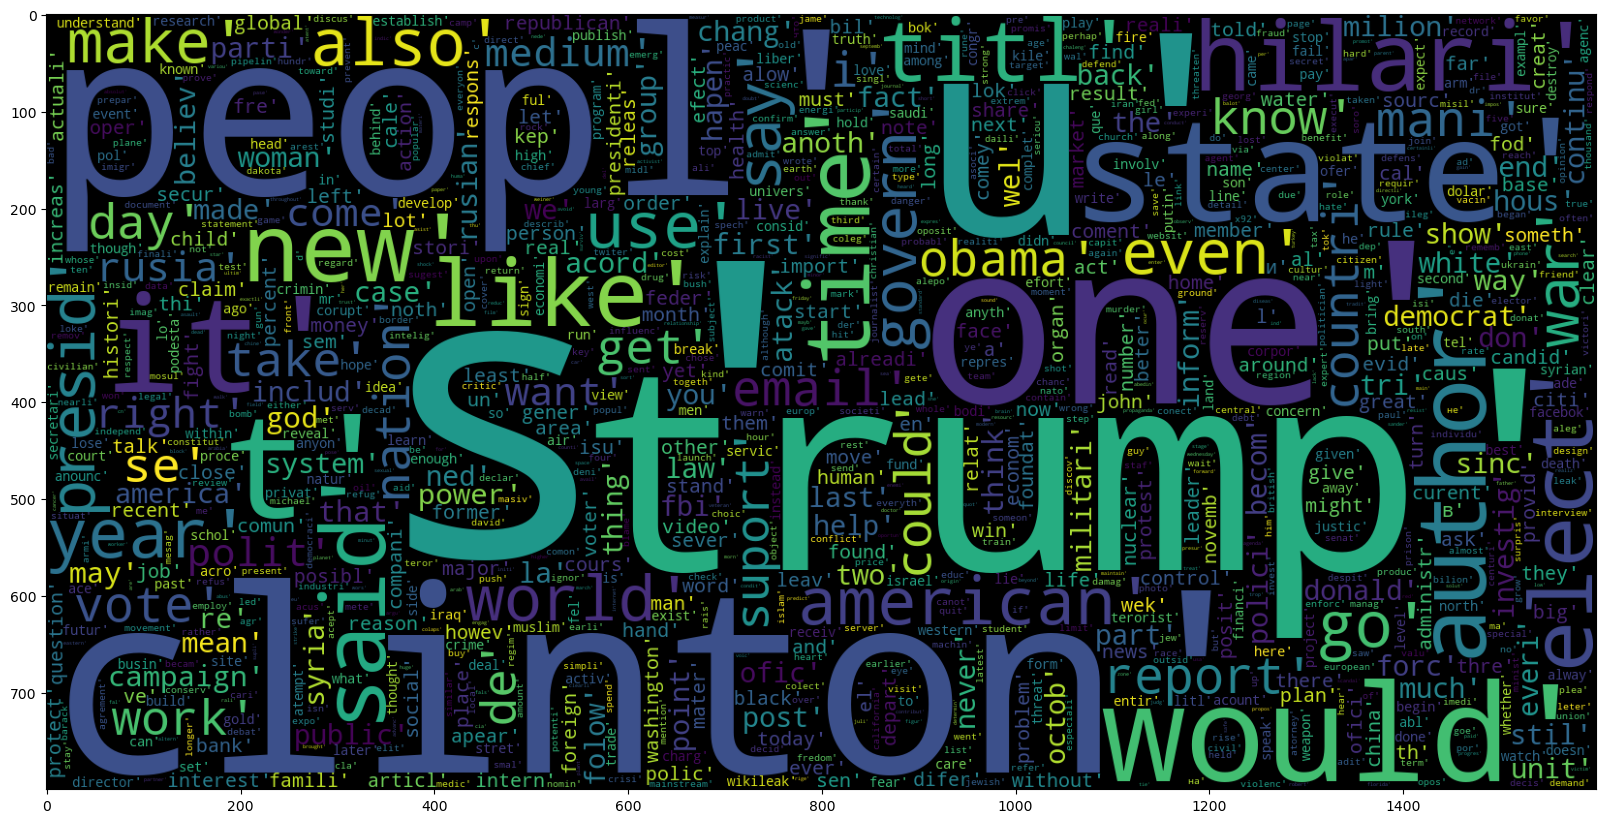

In [30]:
# Create a word cloud for negative news
fake_news_words = train_data['new_text'][train_data['label'] == 1]
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(fake_news_words))
plt.imshow(wc)


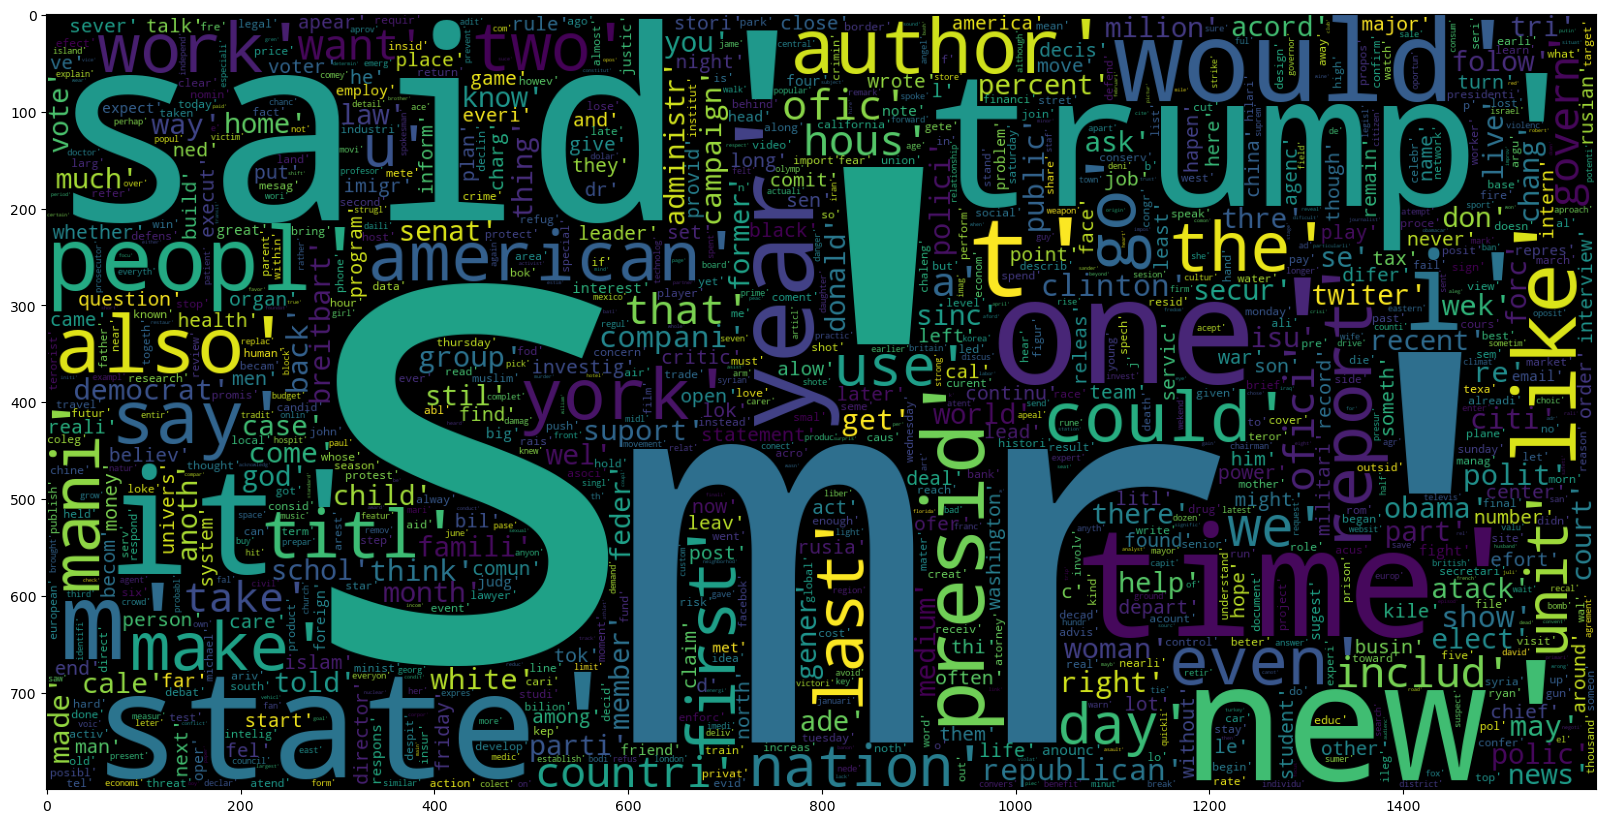

In [31]:
# Create a word cloud for negative news
real_news_words = train_data['new_text'][train_data['label'] == 0]
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(real_news_words))
plt.imshow(wc)

In [32]:
X = train_data['new_text']
y = train_data['label']

In [33]:
# Separating the 80% data for training data and 20% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =26105111)

In [34]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectorizer.fit(X_train)
print('No. of feature_words:', len(vectorizer.get_feature_names_out()))

No. of feature_words: 500000


In [35]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [36]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

Accuracy Score: 96.46634615384615
Classification Report:

               precision    recall  f1-score   support

           0       0.96      0.97      0.96      2055
           1       0.97      0.96      0.96      2105

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160

Confusion Matrix:

 [[1997   58]
 [  89 2016]]


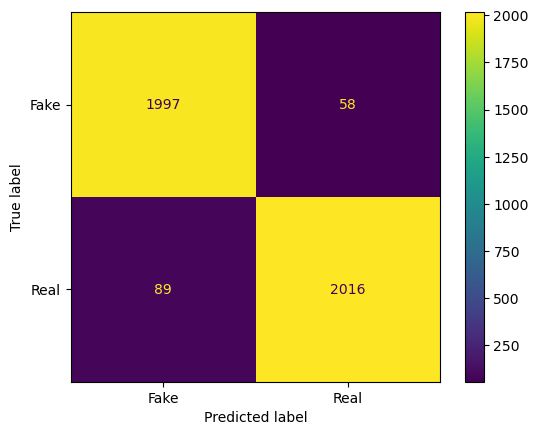

In [37]:
y_pred = LRmodel.predict(X_test)
y_pred_proba = LRmodel.predict_proba(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred)*100)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot()
plt.show()


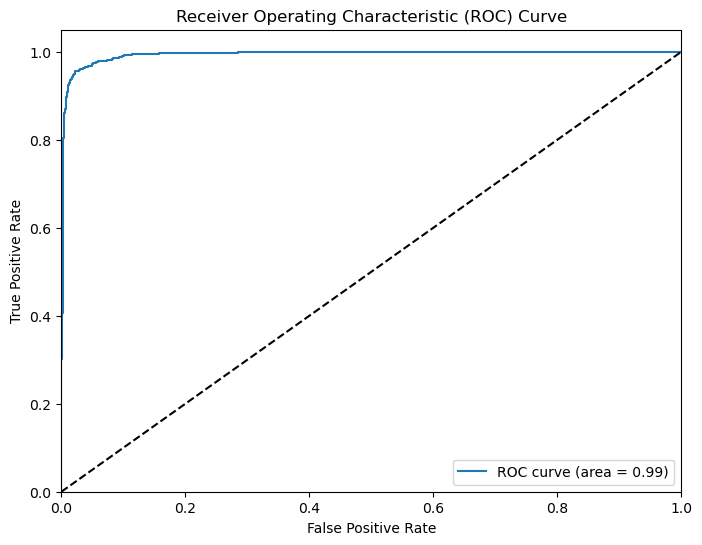

In [38]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import roc_auc_score
y_pred_proba = LRmodel.predict_proba(X_test)[:, 1]
# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [39]:
from sklearn.svm import LinearSVC
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)

C:\Users\wasan\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

Accuracy Score: 97.98076923076923
Classification Report:

               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2055
           1       0.98      0.98      0.98      2105

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



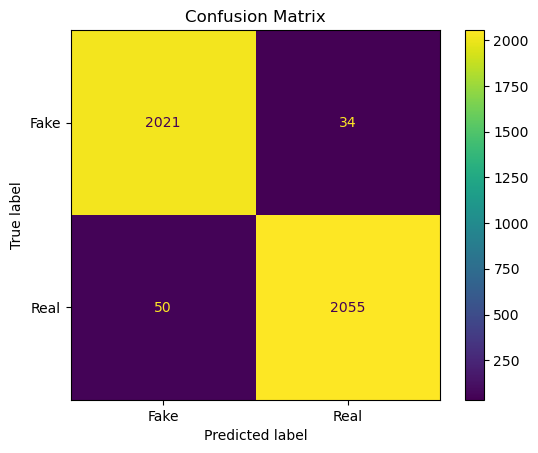

In [40]:
# Making predictions
y_pred = SVCmodel.predict(X_test)

# Calculating and printing accuracy score and classification report
print("Accuracy Score:", accuracy_score(y_test, y_pred)*100)
print("Classification Report:\n\n", classification_report(y_test, y_pred))

# Calculating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

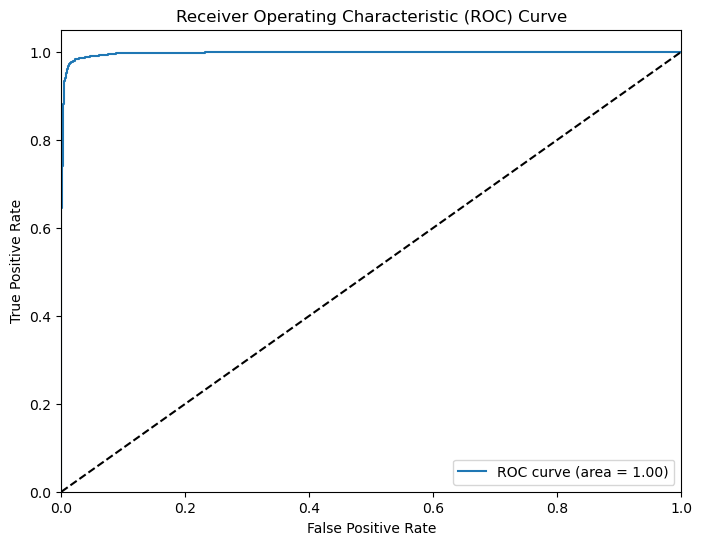

In [41]:
# Getting decision scores
y_scores = SVCmodel.decision_function(X_test)

# Calculating fpr and tpr for ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_scores))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [42]:
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)

BernoulliNB()

Accuracy Score: 86.4423076923077
Classification Report:

               precision    recall  f1-score   support

           0       0.92      0.80      0.85      2055
           1       0.83      0.93      0.87      2105

    accuracy                           0.86      4160
   macro avg       0.87      0.86      0.86      4160
weighted avg       0.87      0.86      0.86      4160



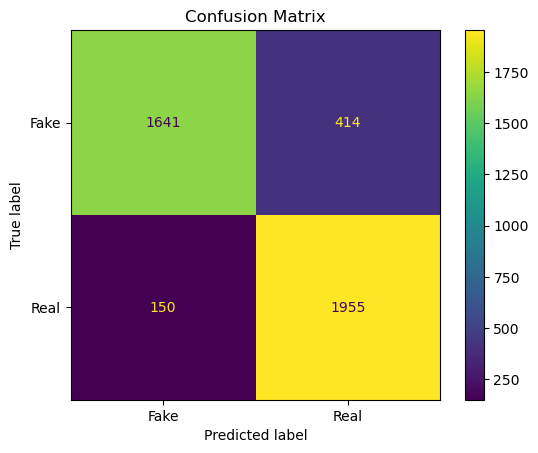

In [43]:
# Making predictions
y_pred = BNBmodel.predict(X_test)

# Calculating and printing accuracy score and classification report
print("Accuracy Score:", accuracy_score(y_test, y_pred)*100)
print("Classification Report:\n\n", classification_report(y_test, y_pred))

# Calculating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

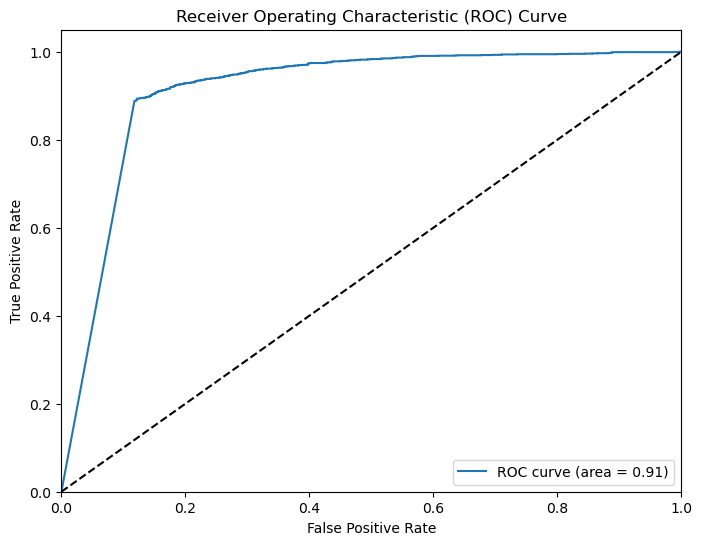

In [44]:
# Getting probability estimates
y_scores = BNBmodel.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Calculating fpr and tpr for ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_scores))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()